In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = "retina"

# Temporary workaround for multiprocessing on macOS
import multiprocessing as mp

mp.set_start_method("fork")

import os
import json
import pickle
import pathlib
import logging
import warnings

import h5py
import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt
from astroquery.mast import Catalogs, Observations

import pymc3 as pm
import theano.tensor as tt

import exoplanet as xo

import tess_world

# Deal with warnings from Theano
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
logging.getLogger("astropy").setLevel(logging.ERROR)
logging.getLogger("theano.gof.compilelock").setLevel(logging.ERROR)
logging.getLogger("exoplanet").setLevel(logging.DEBUG)

# Set up plotting the way we want it
plt.style.use("default")
plt.rcParams["savefig.dpi"] = 100
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Liberation Sans"]
plt.rcParams["font.cursive"] = ["Liberation Sans"]
plt.rcParams["mathtext.fontset"] = "custom"

In [3]:
toi_num = 793

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01]
if not len(toi):
    raise RuntimeError(f"no TOI entry for {toi_num}")
toi = toi.iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")
num_toi = len(tois)

# Extract the planet periods
period_guess = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0_guess = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depth_guess = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
duration_guess = np.array(tois["Duration (hours)"], dtype=float) / 24.0

tois[["TIC ID", "TOI", "Period (days)", "Depth (ppm)", "Duration (hours)"]]

,TIC ID,TOI,Period (days),Depth (ppm),Duration (hours)
738,300013921,793.01,163.987427,2783.281738,2.859115


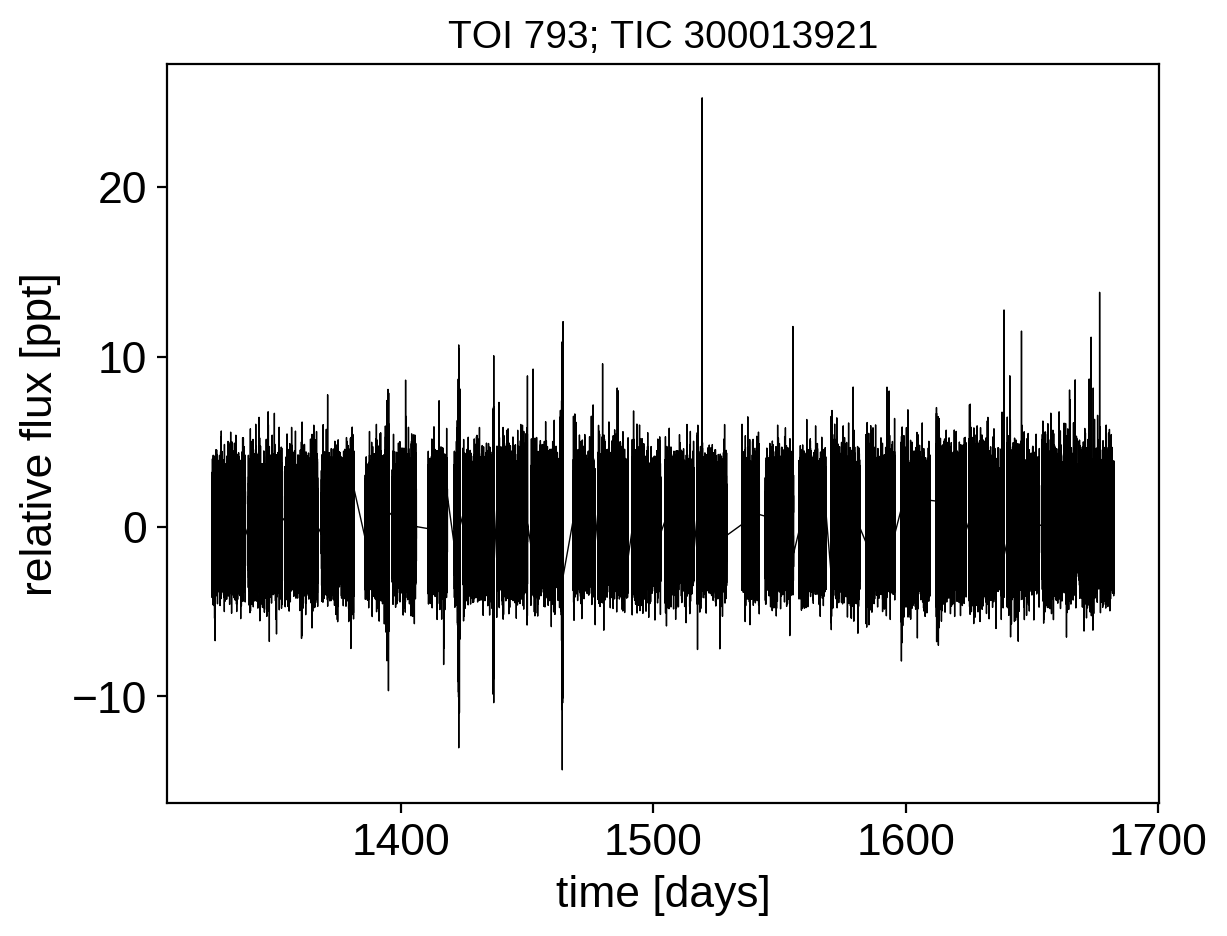

In [4]:
lightkcurve_directory = os.environ.get("LIGHTKURVE_DIRECTORY", "./cache/lightkurve")

# Temporary workaround for slow MAST queries with lightkurve
observations = Observations.query_criteria(
    target_name=f"{tic}",
    radius=0.0001,
    project=["TESS"],
    obs_collection=["TESS"],
    provenance_name="SPOC",
    dataproduct_type="timeseries",
)
if not len(observations):
    raise RuntimeError("no 2-minute cadence data")
products = Observations.get_product_list(observations)
products = products[products["productSubGroupDescription"] == "LC"]
files = Observations.download_products(products, download_dir=lightkcurve_directory)
lcfs = lk.LightCurveCollection([lk.open(file).PDCSAP_FLUX for file in files["Local Path"]])
lc = lcfs.stitch().remove_nans()

# # To be replaced by:
# lcfs = lk.search_lightcurvefile(f"{tic}", mission="TESS")
# print(f"Found {len(lcfs)} light curve file(s)")
# lcfs = lcfs.download_all(download_dir="./cache/lightkurve")
# lc = lcfs.PDCSAP_FLUX.stitch()
# lc = lc.remove_nans().remove_outliers()

x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray(1e3 * (lc.flux - 1), dtype=np.float64)
yerr = np.ascontiguousarray(1e3 * lc.flux_err, dtype=np.float64)

plt.plot(x, y, "k", linewidth=0.5)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.title(f"TOI {toi_num}; TIC {tic}", fontsize=14)

In [5]:
# Deal with single transits
single_transit = period_guess <= 0.0
period_guess[single_transit] = x.max() - x.min()
period_min = np.maximum(np.abs(t0_guess - x.max()), np.abs(x.min() - t0_guess))

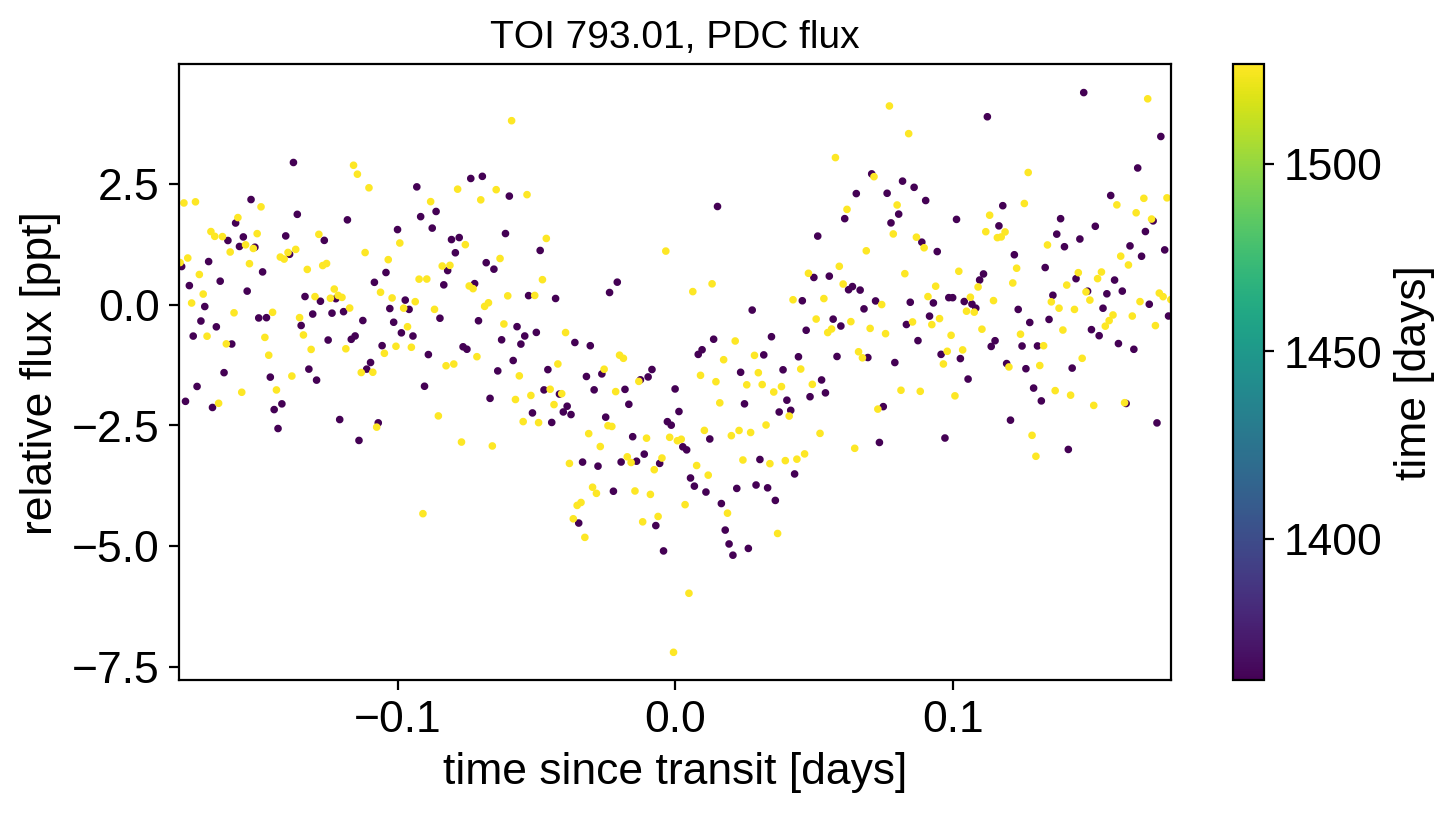

In [6]:
transit_mask = np.zeros_like(x, dtype=bool)
for n in range(num_toi):
    delta = max(1.5 * duration_guess[n], 0.1)
    if single_transit[n]:
        delta = 1.0
    x_fold = (x - t0_guess[n] + 0.5 * period_guess[n]) % period_guess[n] - 0.5 * period_guess[n]
    transit_mask |= np.abs(x_fold) < delta
    
    plt.figure(figsize=(8, 4))
    plt.scatter(x_fold[transit_mask], y[transit_mask], c=x[transit_mask], s=3)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux [ppt]")
    plt.colorbar(label="time [days]")
    plt.title(f"TOI {toi_num}.{n + 1:02d}, PDC flux", fontsize=14)
    plt.xlim(-delta, delta)
    
x = np.ascontiguousarray(x[transit_mask])
y = np.ascontiguousarray(y[transit_mask])
yerr = np.ascontiguousarray(yerr[transit_mask])

In [7]:
def build_model(mask=None):
    if mask is None:
        mask = np.ones_like(x, dtype=bool)
        
    with pm.Model() as model:
        # Stellar parameters
        mean = pm.Normal("mean", mu=0.0, sigma=10.0)
        u = xo.distributions.QuadLimbDark("u")

        # Gaussian process noise model
        sigma = pm.InverseGamma("sigma", alpha=3.0, beta=2 * np.median(yerr))
        log_S_tot = pm.Normal("log_S_tot", mu=np.log(np.median((y[mask] - np.median(y[mask]))**2)), sigma=5.0)
        log_ell = pm.Normal("log_ell", mu=np.log(1.0), sigma=5.0)
        Q = 1.0 / 3.0
        w0 = 2 * np.pi * tt.exp(-log_ell)
        S0 = tt.exp(log_S_tot + log_ell) / (2 * np.pi * Q)
        kernel = xo.gp.terms.SHOTerm(S0=S0, w0=w0, Q=Q)

        # Dealing with period, treating single transits properly
        period_params = []
        periods = []
        for n in range(num_toi):
            if single_transit[n]:
                period = pm.Pareto(f"period_{n}", m=period_min[n], alpha=2./3, testval=period_guess[n])
                period_params.append(period)
            else:
                log_period = pm.Normal(f"log_period_{n}", mu=np.log(period_guess[n]), sigma=1.0)
                period = pm.Deterministic(f"period_{n}", tt.exp(log_period))
                period_params.append(log_period)
            periods.append(period)
        period = pm.Deterministic("period", tt.stack(periods))
        
        # Transit parameters
        t0 = pm.Normal("t0", mu=t0_guess, sigma=1.0, shape=num_toi)
        log_dur = pm.Normal("log_duration", mu=np.log(duration_guess), sigma=5.0, shape=num_toi)        
        b = xo.distributions.UnitUniform("b", shape=num_toi)
        log_depth = pm.Normal("log_depth", mu=np.log(depth_guess), sigma=5.0, shape=num_toi)
        depth = pm.Deterministic("transit_depth", tt.exp(log_depth))
        dur = pm.Deterministic("transit_duration", tt.exp(log_dur))

        # Compute the radius ratio from the transit depth, impact parameter, and
        # limb darkening parameters making the small-planet assumption
        u1 = u[0]
        u2 = u[1]
        mu = tt.sqrt(1 - b ** 2)
        ror = pm.Deterministic("ror", tt.sqrt(1e-3 * depth * (1 - u1 / 3 - u2 / 6) / (1 - u1 * (1 - mu) - u2 * (1 - mu) ** 2)))

        # Set up the orbit
        orbit = xo.orbits.KeplerianOrbit(period=period, duration=dur, t0=t0, b=b)
        
        # Geometric probability
        pm.Potential("geom", tt.log(orbit.dcosidb))

        # We're going to track the implied density for reasons that will become clear later
        pm.Deterministic("rho_circ", orbit.rho_star)

        # Set up the mean transit model
        star = xo.LimbDarkLightCurve(u)

        def lc_models(t):
            return 1e3 * star.get_light_curve(orbit=orbit, r=ror, t=t)

        def lc_model(t):
            return mean + tt.sum(lc_models(t), axis=-1)

        # Finally the GP observation model
        gp = xo.gp.GP(kernel, x[mask], yerr[mask] ** 2 + sigma ** 2, mean=lc_model)
        gp.marginal("obs", observed=y[mask])

        # Double check that everything looks good - we shouldn't see any NaNs!
        print(model.check_test_point())

        # Optimize the model
        map_soln = model.test_point
        map_soln = xo.optimize(map_soln, [sigma])
        map_soln = xo.optimize(map_soln, [mean, log_depth, b, log_dur])
        map_soln = xo.optimize(map_soln, [sigma, log_S_tot, log_ell])
        map_soln = xo.optimize(map_soln, [mean, u])
        map_soln = xo.optimize(map_soln, period_params)
        map_soln = xo.optimize(map_soln)
        
        # Save some of the key parameters
        model.map_soln = map_soln
        model.lc_models = lc_models
        model.lc_model = lc_model
        model.gp = gp
        model.mask = mask
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = yerr[mask]
        
    return model


def build_model_with_sigma_clipping(sigma=5.0, maxiter=10):
    ntot = len(x)
    mask = np.ones_like(x, dtype=bool)
    pred = np.zeros_like(y)
    for i in range(maxiter):
        print(f"Sigma clipping round {i + 1}")
                
        with build_model(mask) as model:
            pred[mask] = xo.eval_in_model(model.gp.predict() + model.lc_model(x[mask]), model.map_soln)
            if np.any(~mask):
                pred[~mask] = xo.eval_in_model(model.gp.predict(x[~mask]) + model.lc_model(x[~mask]), model.map_soln)
        
        resid = y - pred
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        
        print(f"... clipping {(~mask).sum()} of {len(x)} ({100 * (~mask).sum() / len(x):.1f}%)")
        
        if ntot == mask.sum():
            break
        ntot = mask.sum()
        
    return model

model = build_model_with_sigma_clipping()

Sigma clipping round 1
mean                 -3.22
u_quadlimbdark__     -2.77
sigma_log__          -0.53
log_S_tot            -2.53
log_ell              -2.53
log_period_0         -0.92
t0                   -0.92
log_duration         -2.53
b_logodds__          -1.39
log_depth            -2.53
obs                -981.42
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [sigma]
7it [00:00,  7.78it/s, logp=-9.900340e+02] 
message: Optimization terminated successfully.
logp: -1007.2277287620432 -> -990.03397925919
optimizing logp for variables: [log_duration, b, log_depth, mean]
28it [00:00, 93.35it/s, logp=-9.841170e+02] 
message: Optimization terminated successfully.
logp: -990.03397925919 -> -984.1169553806184
optimizing logp for variables: [log_ell, log_S_tot, sigma]
19it [00:00, 86.22it/s, logp=-9.771575e+02] 
message: Optimization terminated successfully.
logp: -984.1169553806184 -> -977.157507471311
optimizing logp for variables: [u, mean]
9it [00:00, 45.73it/s, logp=-9.766832e+02] 
message: Optimization terminated successfully.
logp: -977.157507471311 -> -976.6831948486981
optimizing logp for variables: [log_period_0]
151it [00:00, 296.94it/s, logp=-9.766814e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -976.6831948486868 -> -976.6814488541567
optimizing logp for variables: [log_

... clipping 0 of 515 (0.0%)


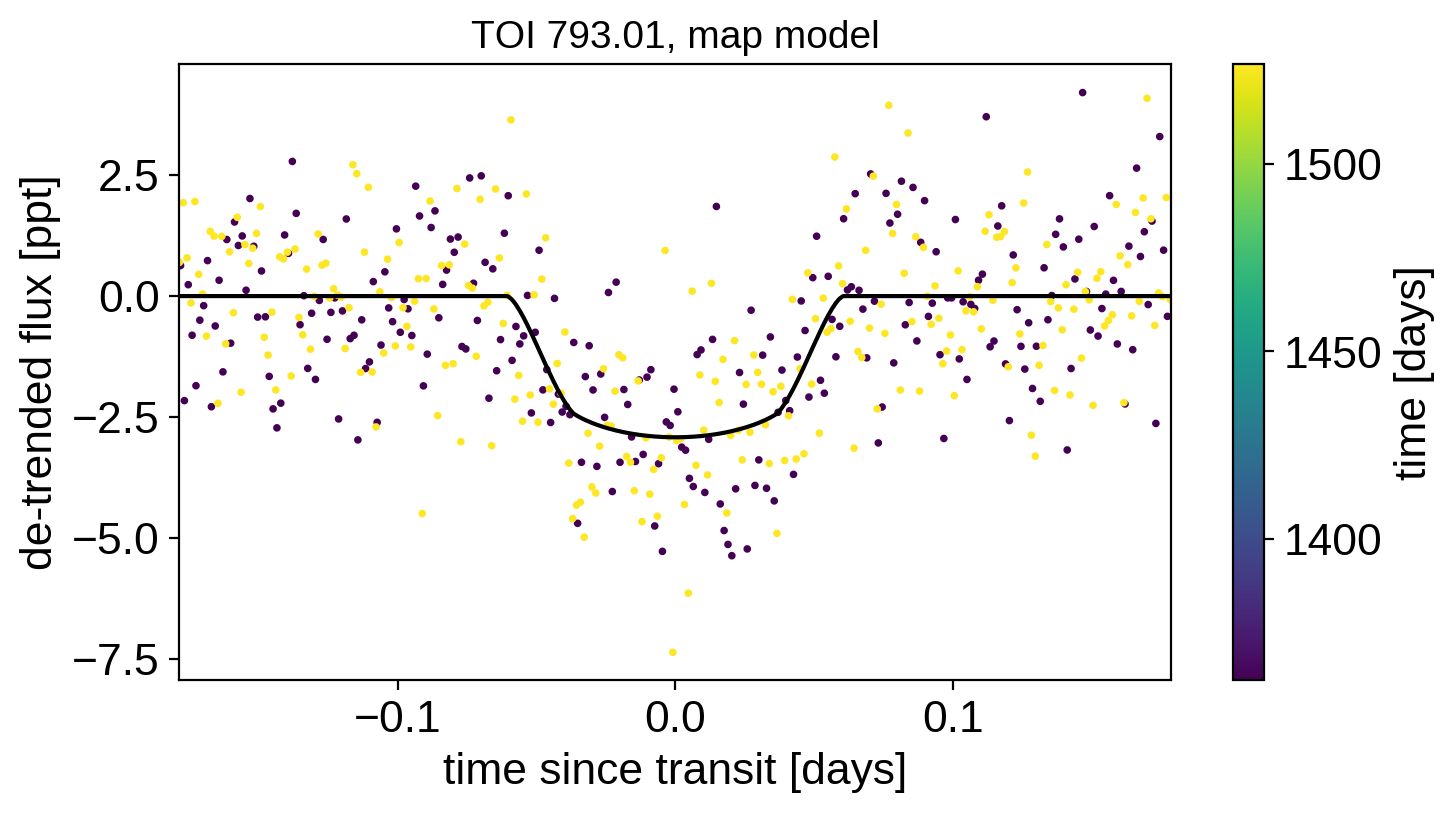

In [8]:
with model:
    gp_pred, lc_pred = xo.eval_in_model([model.gp.predict(), model.lc_models(model.x)], model.map_soln)

transit_mask = np.zeros_like(x, dtype=bool)
for n in range(num_toi):
    t0 = model.map_soln["t0"][n]
    period = model.map_soln["period"][n]
    x_fold = (model.x - t0 + 0.5 * period) % period - 0.5 * period
    
    plt.figure(figsize=(8, 4))
    plt.scatter(x_fold, model.y - gp_pred - model.map_soln["mean"], c=model.x, s=3)
    
    inds = np.argsort(x_fold)
    plt.plot(x_fold[inds], lc_pred[inds, n], "k")
    
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux [ppt]")
    plt.colorbar(label="time [days]")
    plt.title(f"TOI {toi_num}.{n + 1:02d}, map model", fontsize=14)
    delta = max(1.5 * duration_guess[n], 0.1)
    if single_transit[n]:
        delta = 1.0
    plt.xlim(-delta, delta)

In [9]:
np.random.seed(toi_num)
with model:
    trace = pm.sample(
        tune=2000,
        draws=2000,
        start=model.map_soln,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_depth, b, log_duration, t0, log_period_0, log_ell, log_S_tot, sigma, u, mean]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [02:19<00:00, 57.27draws/s] 
The number of effective samples is smaller than 25% for some parameters.


In [62]:
output_directory = pathlib.Path(os.environ.get("OUTPUT_DIRECTORY", "."))

# Save the model
with open(output_directory / "model.pkl", "wb") as f:
    pickle.dump(model, f, -1)

# Save the MAP solution
with open(output_directory / "map_soln.json", "w") as f:
    json.dump(model.map_soln, f, indent=2, cls=tess_world.NumpyEncoder)

# Save the summary statistics
summary = pm.summary(trace, round_to="none")
summary.to_csv(output_directory / "summary.csv")

# Save the trace
df = pm.trace_to_dataframe(trace, include_transformed=True)
stats = pd.DataFrame(dict((name, trace.get_sampler_stats(name)) for name in trace.stat_names))
with h5py.File(output_directory / "trace.h5", "w") as f:
    f.create_dataset("trace", data=df.to_records(index=False))
    f.create_dataset("stats", data=stats.to_records(index=False))

AttributeError: Can't pickle local object 'build_model.<locals>.lc_model'

In [19]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean,0.119,0.675,-0.573,0.858,0.047,0.033,207.0,207.0,839.0,230.0,1.01
log_S_tot,-5.055,3.312,-11.185,1.602,0.146,0.103,514.0,514.0,540.0,318.0,1.01
log_ell,1.444,5.682,-8.985,11.970,0.184,0.130,954.0,954.0,961.0,1256.0,1.00
log_period_0,5.100,0.000,5.100,5.100,0.000,0.000,2915.0,2915.0,2964.0,2476.0,1.00
t0[0],1362.368,0.003,1362.362,1362.373,0.000,0.000,3179.0,3179.0,3191.0,2683.0,1.00
log_duration[0],-2.289,0.079,-2.413,-2.135,0.002,0.001,2201.0,2130.0,2426.0,1657.0,1.00
log_depth[0],1.066,0.083,0.917,1.226,0.002,0.001,2329.0,2153.0,2660.0,2048.0,1.00
u[0],0.681,0.461,0.000,1.484,0.009,0.006,2676.0,2676.0,2282.0,1714.0,1.00
u[1],0.012,0.408,-0.748,0.731,0.007,0.006,3214.0,2331.0,3173.0,2909.0,1.00
sigma,0.388,0.076,0.248,0.525,0.001,0.001,3195.0,3195.0,3108.0,2660.0,1.00


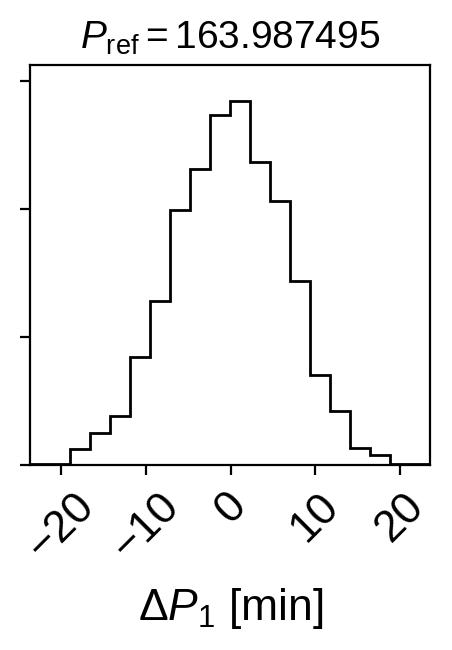

In [11]:
median_period = np.median(trace["period"], axis=0)
samples = np.array(trace["period"])
samples[:, ~single_transit] = 24 * 60 * (samples[:, ~single_transit] - median_period[None, ~single_transit])
samples[:, single_transit] = np.log10(samples[:, single_transit])
labels = [f"$\log_{{10}} P_{n + 1} / \mathrm{{day}}$" if single_transit[n] else f"$\Delta P_{n + 1}$ [min]" for n in range(num_toi)]

fig = corner.corner(samples, labels=labels)
for n, ax in enumerate(np.diag(np.array(fig.axes).reshape(num_toi, num_toi))):
    if single_transit[n]:
        continue
    ax.set_title(f"$P_\mathrm{{ref}} = {median_period[n]:.6f}$", fontsize=14)

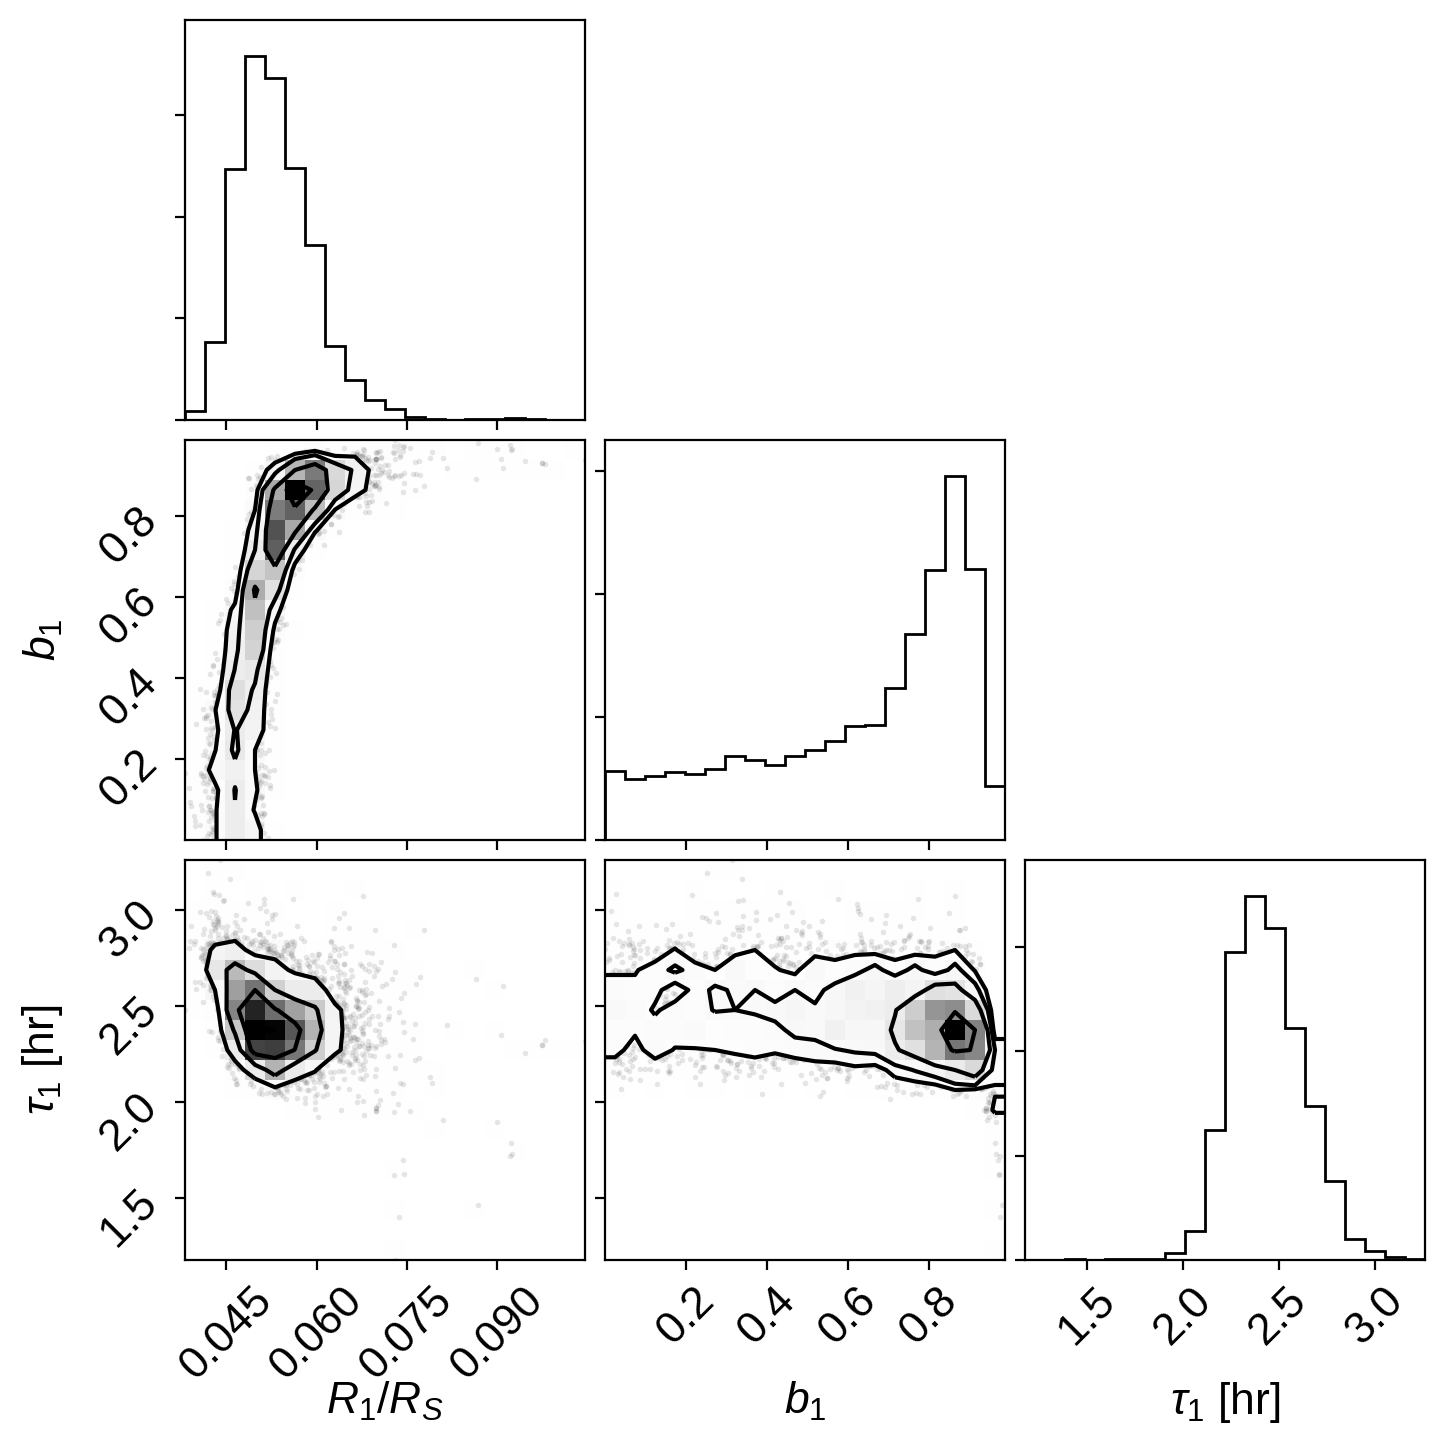

In [12]:
samples = np.concatenate((
    trace["ror"],
    trace["b"],
    trace["transit_duration"] * 24,
), axis=1)
labels = [f"$R_{n + 1} / R_S$" for n in range(num_toi)]
labels += [f"$b_{n + 1}$" for n in range(num_toi)]
labels += [f"$\\tau_{n + 1}$ [hr]" for n in range(num_toi)]

_ = corner.corner(samples, labels=labels)

rho_star = 1.87231 ± 0.443885


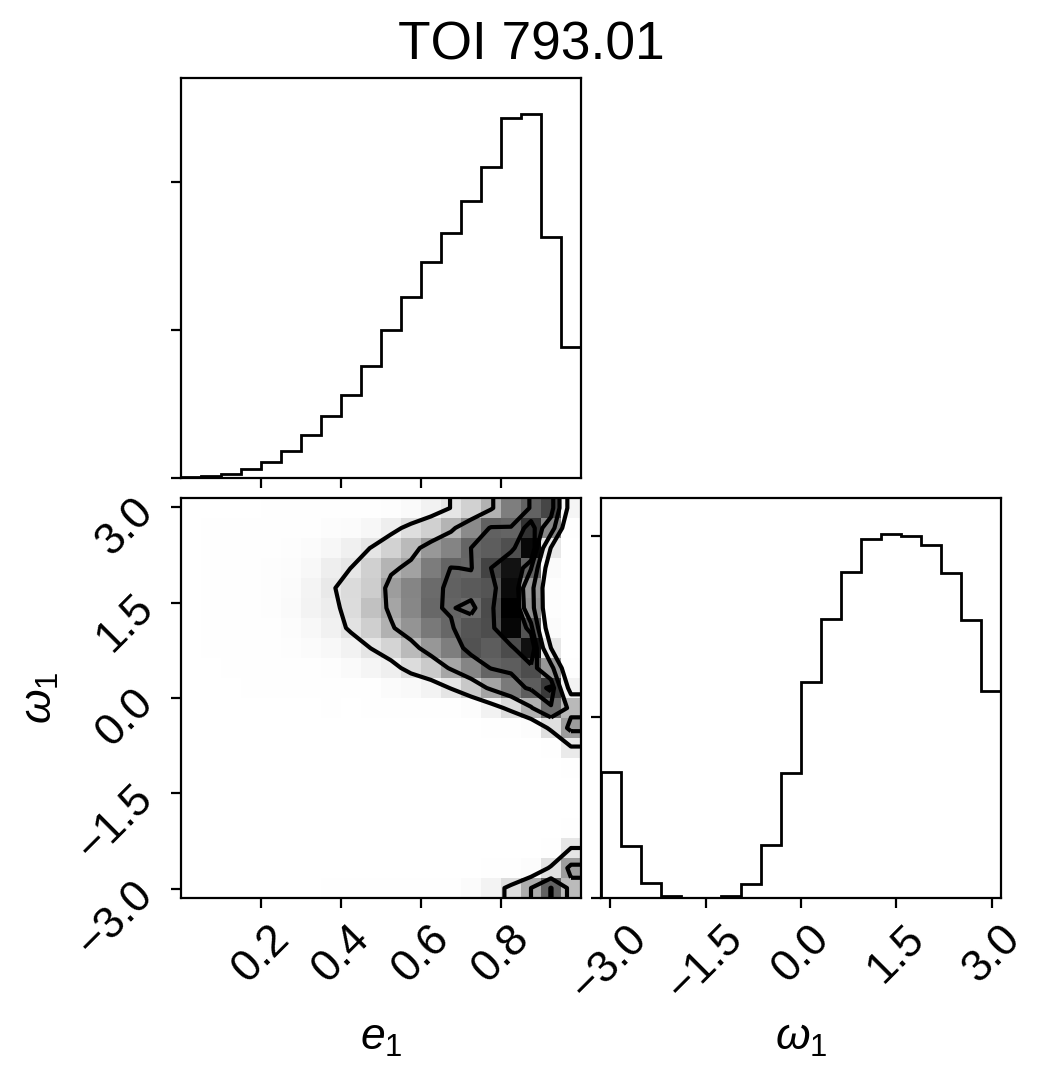

In [13]:
star = Catalogs.query_object(f"TIC {tic}", catalog="TIC", radius=0.001)
tic_rho_star = float(star["rho"]), float(star["e_rho"])
if np.all(np.isfinite(tic_rho_star)):
    
    print("rho_star = {0} ± {1}".format(*tic_rho_star))

    # Extract the implied density from the fit
    rho_circ = np.repeat(trace["rho_circ"], 500, axis=0)
    period = np.repeat(trace["period"], 500, axis=0)

    # Sample eccentricity and omega uniformly
    ecc = np.random.uniform(0, 1, len(rho_circ))
    omega = np.random.uniform(-np.pi, np.pi, len(rho_circ))

    # Compute the "g" parameter from Dawson & Johnson and what true
    # density that implies
    g = (1 + ecc * np.sin(omega)) / np.sqrt(1 - ecc ** 2)
    rho = rho_circ / g[:, None] ** 3

    # Re-weight these samples to get weighted posterior samples
    log_weights = -0.5 * ((rho - tic_rho_star[0]) / tic_rho_star[1]) ** 2

    for n in range(num_toi):
        weights = np.exp(log_weights[:, n] - np.max(log_weights[:, n]))
        if single_transit[n]:
            samples = np.vstack((ecc, omega, np.log10(period[:, n]))).T
            labels = [f"$e_{n + 1}$", f"$\omega_{n + 1}$", f"$\log_{{10}} P_{n + 1} / \mathrm{{day}}$"]
        else:
            samples = np.vstack((ecc, omega)).T
            labels = [f"$e_{n + 1}$", f"$\omega_{n + 1}$"]
            
        fig = corner.corner(
            samples,
            weights=weights,
            plot_datapoints=False,
            labels=labels,
        )
        fig.suptitle(f"TOI {toi_num}.{n + 1:02d}")
        
else:
    print("The TIC has no measured density")